In [21]:
import glob
import itertools
import json
import operator
import os

In [22]:
YEAR = 2009
REGULATION = 'Ustawa z dnia 23 kwietnia 1964 r. - Kodeks cywilny'
ARTICLE = 445
CASES = {
    'szkoda',
    'szkody',
    'szkodzie',
    'szkodę',
    'szkodą',
    'szkodzie',
    'szkodo',
    'szkody',
    'szkód',
    'szkodom',
    'szkody',
    'szkodami',
    'szkodach',
    'szkody'
}
PATH = 'F:\\saos\\data\\json\\judgments-*'
FILENAMES_FOR_YEAR = f'judgments_from_{YEAR}.json'
HISTOGRAMS_DIR = 'histograms'

In [23]:
import os
from itertools import tee, filterfalse
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter


def partition(pred, iterable):
    t1, t2 = tee(iterable)
    return filterfalse(pred, t1), filter(pred, t2)


def plot_histograms(money_values):
    plot_data(list(money_values), label='all')
    less_than_million, more_than_million = partition(lambda x: x >= 1e6, money_values)
    plot_data(list(less_than_million), label='less_than_million')
    plot_data(list(more_than_million), label='more_than_million')


def format_value(value, _):
    if value < 1e3:
        divider = 1
    elif value < 1e6:
        divider = 1e3
        suffix = 'tys.'
    elif value < 1e9:
        divider = 1e6
        suffix = 'mln'
    else:
        divider = 1e9
        suffix = 'mld'
    value = int(value // divider)
    return f'{value} {suffix}' if divider != 1 else str(value)


def plot_data(data, label):
    title_part = {
        'all': 'wszystkich wartości pieniężnych',
        'less_than_million': 'wartości pieniężnych poniżej 1 mln złotych',
        'more_than_million': 'wartości pieniężnych powyżej 1 mln złotych'
    }
    number_of_bins = 40
    x_min = min(data)
    x_max = max(data)
    plt.hist(data, bins=np.logspace(np.log10(x_min), np.log10(x_max), number_of_bins), rwidth=0.9)
    ax = plt.gca()
    ax.set_xlim(xmin=x_min, xmax=x_max)
    ax.set_yscale('log', nonposy='clip')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(format_value))
    title = wrap(f'Histogram dla {title_part[label]} pojawiających się w tekstach orzeczeń z roku {YEAR}', width=60)
    plt.title('\n'.join(title))
    plt.xlabel('złotych')
    plt.ylabel('Liczba odniesień w tekstach')
    if not os.path.exists(HISTOGRAMS_DIR):
        os.makedirs(HISTOGRAMS_DIR)
    plt.savefig(os.path.join(HISTOGRAMS_DIR, label + '.png'))
    plt.show()

In [24]:
import re


def extract_money(judgment_text):
    regex = '''
        (?:
            [1-9]\d*                    # digits, first being non-zero
            (?:[\. ]\d+)*               # . or space to group by thousands e.g. 123 742  or 659.041.328
        )+
        (?:,\d+)?\                      # fractional part followed by space   e.g. 2,5   391.678,99 
        (?:
            tys\.? |mln\.? |mld\.? |
            \(\w+[ \w+]*\)\             # e.g.  360 (trzysta sześćdziesiąt)
        )?
        (?=zł)
    '''
    return map(normalize, re.findall(regex, judgment_text, re.VERBOSE))


def normalize(money_text: str):
    money_text = money_text.strip()  # space at the end
    d = {'tys': 3, 'mln': 6, 'mld': 9}

    if re.match('(?:[1-9]\d*(?:[\. ]\d+)*)+\s*\([\w+\s]+\)',
                money_text):  # e.g. '360 (trzysta sześćdziesiąt)'  => extract 360
        money_text = money_text[:money_text.find('(')]

    money_text = money_text.replace('.', ' ').strip()  # '3.319.726' -> '3 319 726'

    if not any(money_text.endswith(key) for key in d):  # does not contain tys. or mln or mln
        try:  # '90 853,33'  => ignore fractional part ,33
            money_text = money_text[:money_text.index(',')]
        except ValueError:  # does not contain fractional part
            pass
        return int(money_text.replace(' ', ''))

    *numbers, word = money_text.split(' ')
    if len(numbers) == 1:  # e.g.  52 mln  -> 52000000
        return float(numbers[0].replace(',', '.')) * 10 ** d[word]
    else:  # e.g. 802 054 tys. -> 802054
        return int(''.join(numbers))


def references_article_of_regulation(reference, regulation, article):
    regex = 'art\.\s+' + str(article)
    return reference['journalTitle'].lower() == regulation.lower() and bool(re.search(regex, reference['text']))


def contains_any_word_case(judgment_text, cases):
    regex = '|'.join(rf'\b{case}\b' for case in cases)
    return bool(re.search(regex, judgment_text))

In [25]:
year_pattern = str(YEAR) + '-\d{2}-\d{2}'


def get_filenames_with_judgments_for_year(judgment_filenames):
    with open(FILENAMES_FOR_YEAR, 'w') as file:
        filenames_for_year = filter(contains_judgments_from_year, judgment_filenames)
        json.dump(list(filenames_for_year), file)

        
def contains_judgments_from_year(filename):
    return any(re.match(year_pattern, item['judgmentDate']) for item in get_judgments(filename))


def get_judgments(filename):
    with open(filename, encoding='utf-8') as file:
        content = json.load(file)
    return (item for item in content['items'] if re.match(year_pattern, item['judgmentDate']))

In [26]:
judgment_filenames = glob.glob(PATH)

if not os.path.isfile(FILENAMES_FOR_YEAR):
    get_filenames_with_judgments_for_year(judgment_filenames)
    
with open(FILENAMES_FOR_YEAR) as file:
    filenames_with_judgments_for_year = json.load(file)
    judgments = list(itertools.chain.from_iterable(map(get_judgments, filenames_with_judgments_for_year)))

In [27]:
judgment_texts = list(map(operator.itemgetter('textContent'), judgments))
referenced_regulations = itertools.chain.from_iterable(map(operator.itemgetter('referencedRegulations'), judgments))

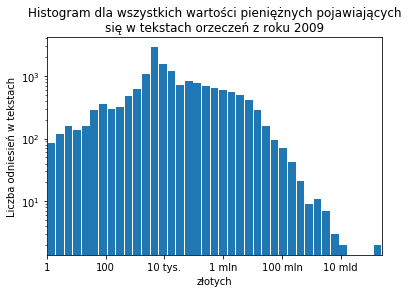

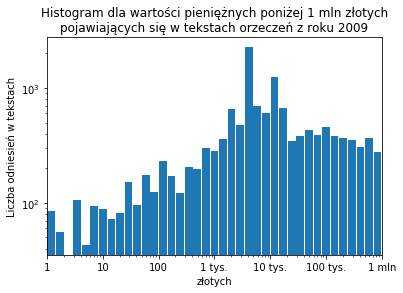

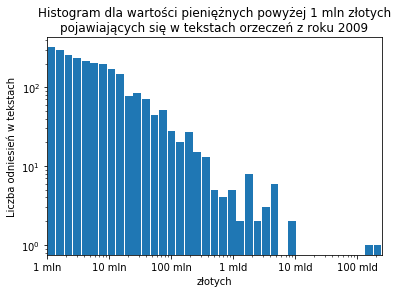

In [28]:
money_values = list(itertools.chain.from_iterable(extract_money(judgment_text) for judgment_text in judgment_texts))
plot_histograms(money_values)

In [29]:
reference_count = sum(references_article_of_regulation(reference, REGULATION, ARTICLE)
                      for reference in referenced_regulations)
print(f'Ilość odwołań do art. {ARTICLE} ustawy "{REGULATION}": {reference_count}')

Ilość odwołań do art. 445 ustawy "Ustawa z dnia 23 kwietnia 1964 r. - Kodeks cywilny": 37


In [31]:
texts_with_szkoda_count = sum(contains_any_word_case(judgment_text, CASES) for judgment_text in judgment_texts)
print(f'Liczba orzeczeń zawierających słowo szkoda w dowolnej formie fleksyjnej: {texts_with_szkoda_count}')

Liczba orzeczeń zawierających słowo szkoda w dowolnej formie fleksyjnej: 733
